<h1 align="center">Logistic Regression in TensorFlow</h1>

In [2]:
import numpy as np
import pandas as pd
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
pima_df = pd.read_csv(url, header=None)

# Feature Information

For Each Attribute: (all numeric-valued)
    
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

In [4]:
pima_df.columns = ['n_pregnant', 'glucose_conc', 'bp', 
                   'skin_fold_thickness', 'serum_insulin', 'bmi', 'diabetes_ped_func', 
                   'age', 'has_diabetes']

In [5]:
pima_df.head()

,n_pregnant,glucose_conc,bp,skin_fold_thickness,serum_insulin,bmi,diabetes_ped_func,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Map the values in the target column: 1 -> 'yes', 0 -> 'no'
pima_df = pima_df.assign(has_diabetes=pima_df.has_diabetes.map(lambda v: 'yes' if v == 1 else 'no'))

In [7]:
pima_df.head()

,n_pregnant,glucose_conc,bp,skin_fold_thickness,serum_insulin,bmi,diabetes_ped_func,age,has_diabetes
0,6,148,72,35,0,33.6,0.627,50,yes
1,1,85,66,29,0,26.6,0.351,31,no
2,8,183,64,0,0,23.3,0.672,32,yes
3,1,89,66,23,94,28.1,0.167,21,no
4,0,137,40,35,168,43.1,2.288,33,yes


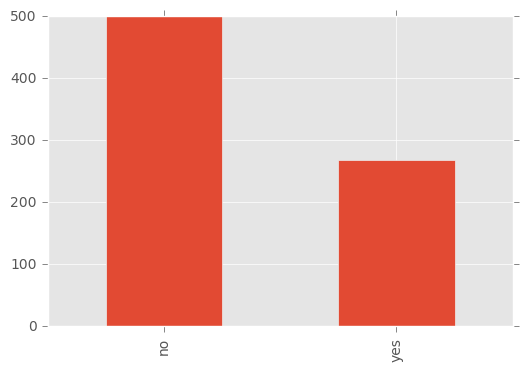

In [8]:
# Check for class imbalance
pima_df.has_diabetes.value_counts().plot(kind='bar')

In [9]:
len(pima_df)

768

In [10]:
from sklearn.preprocessing import StandardScaler

feature_array = pima_df.drop('has_diabetes', axis=1).astype(np.float64).values
scaled_features = StandardScaler().fit_transform(feature_array)

In [11]:
label_array = pima_df.has_diabetes.map(lambda v: 1 if v == 'yes' else 0).astype(np.int64).values

In [12]:
import tensorflow as tf

In [13]:
n = 5000
k = 200

tf.reset_default_graph()

weights = tf.get_variable(dtype=np.float64, 
                      name='weights', 
                      shape=(8, 1),
                      initializer=tf.truncated_normal_initializer(mean=0.0, stddev=1.0))

features = tf.placeholder(shape=(768, 8), dtype=np.float64, name='features')
labels = tf.placeholder(shape=768, dtype=np.int64, name='labels')

# Calculate w * X
w_times_f = tf.matmul(features, weights, name='w_dot_x')

# Calculate P(X) = 1 / 1 + exp(w * X)
one = tf.constant(1.0, dtype=np.float64)
probs = tf.squeeze(1.0 / (1.0 + tf.exp(w_times_f)), name='logistic_function')

# 1-P(X)
one_minus_probs = tf.subtract(one, probs, name='one_minus_probs')
one_minus_labels = tf.subtract(one, tf.cast(labels, np.float64), name='one_minus_y')

# Cross-enropy loss = - [ P(X) * ln \hat{P(X)}  + (1-P(X)) * ln \hat{1-P(X)} ]
cross_entropy_loss = -tf.add(tf.multiply(tf.cast(labels, np.float64), tf.log(probs)), 
                            tf.multiply(one_minus_labels, tf.log(one_minus_probs)), 
                                   name='cross_entropy_loss')
loss_function = tf.reduce_mean(cross_entropy_loss, name='loss_function')

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.02)
train_op = optimizer.minimize(loss_function, name='loss_minimizer')

losses = []

with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    
    fd = {features: scaled_features, labels: label_array}

    for i in range(1, n+1):
        _, current_loss = s.run([train_op, loss_function], feed_dict=fd)
        losses.append(current_loss)
            
    current_probs = probs.eval(session=s, feed_dict=fd)   



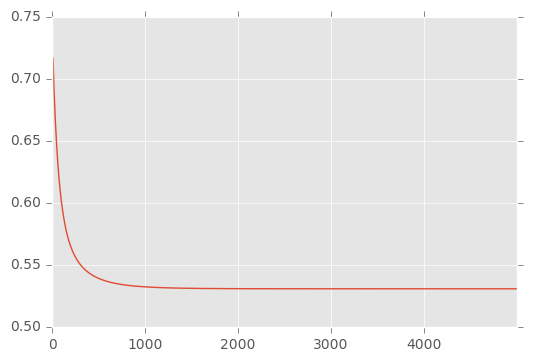

In [14]:
loss_vals = pd.Series(losses)
loss_vals.rolling(10).mean().plot()

In [15]:
current_predictions = np.where(current_probs > 0.5, 1.0, 0.0).astype(np.int)

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(label_array, current_predictions)

0.74609375